## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from pathlib import Path


import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [3]:
import torch
print("CUDA available? ", torch.cuda.is_available())
print("MPS available?  ", torch.backends.mps.is_available())

CUDA available?  False
MPS available?   True


## 3. Prepare Data

In [4]:
from pathlib import Path

ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
data_dir = ROOT / "data"
data_dir.mkdir(exist_ok=True)


In [5]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer",
                  "dog", "frog", "horse", "ship", "truck"]
class_idx = {
    str(i): [f"cifar10_{label}", label] for i, label in enumerate(cifar10_labels)
}
(data_dir / "cifar10_class_index.json").write_text(json.dumps(class_idx, indent=2))

472

In [6]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
with (ROOT / "data" / "cifar10_class_index.json").open() as fh:
    class_idx = json.load(fh)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])


In [8]:
def cifar10_with_custom_labels(root, transform, custom_label, train=False):
    dataset = dsets.CIFAR10(root=root, train=train, download=True, transform=transform)
    dataset.classes = custom_label
    dataset.class_to_idx = {label: idx for idx, label in enumerate(custom_label)}
    return dataset


In [9]:
# CIFAR-10 loader (test split)
normal_data = cifar10_with_custom_labels(
    root=ROOT / ".data",    # same ROOT you set earlier
    transform=transform,
    custom_label=idx2label,
    train=False,
)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)


In [10]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


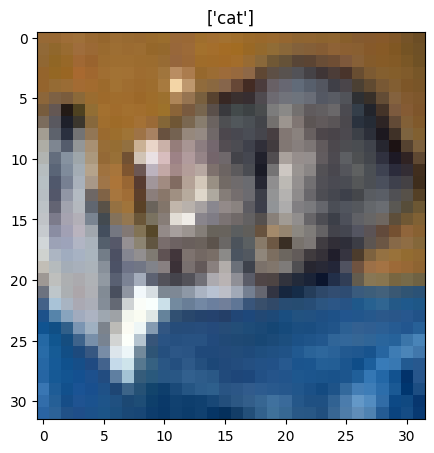

In [11]:
normal_iter = iter(normal_loader)
images, labels = next(normal_iter)

print("True Image & True Label")
imshow(
    torchvision.utils.make_grid(images, normalize=True),
    [normal_data.classes[i] for i in labels],
)


## 4. Download the Inception v3

In [12]:
ROOT = Path.cwd() if (Path.cwd() / "model_best.pth.tar").exists() else Path.cwd().parent

def build_cifar_resnet18(num_classes=10):
    model = models.resnet18(weights=None)
    # thay conv1 7x7 stride2 -> 3x3 stride1, và bỏ maxpool để giữ kích thước feature map phù hợp
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def load_checkpoint(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location="cpu")
    missing, unexpected = model.load_state_dict(checkpoint["state_dict"], strict=False)
    if missing or unexpected:
        raise RuntimeError(f"Checkpoint mismatch: missing {missing}, unexpected {unexpected}")
    return model

device = torch.device("mps" if torch.mps.is_available() else "mps" if torch.mps.is_available()  else "cpu")
print(f"Device use to train:", device)
model = build_cifar_resnet18().to(device)
model = load_checkpoint(model, ROOT / "model_best.pth.tar")
model.to(device).eval()

Device use to train: mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

True Image & Predicted Label


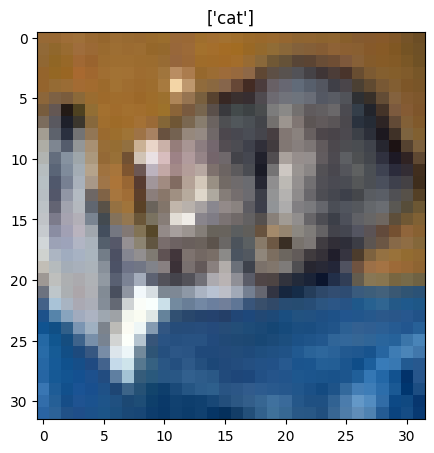

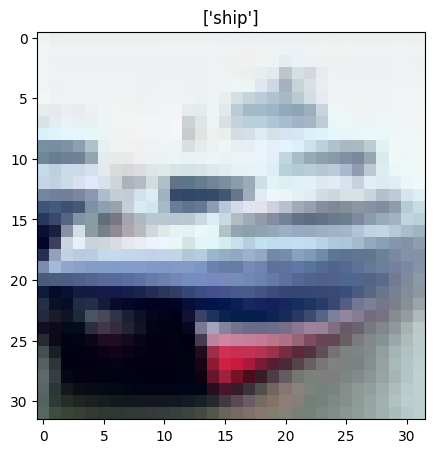

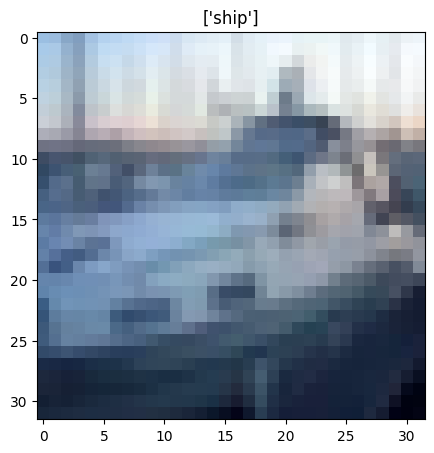

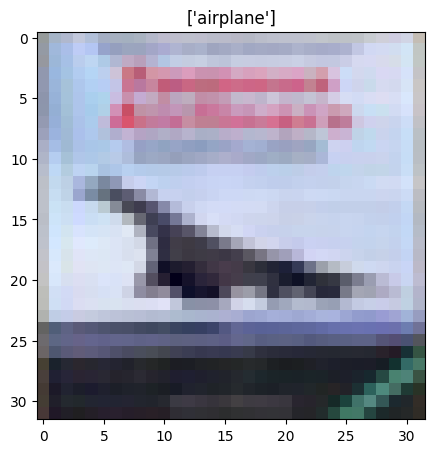

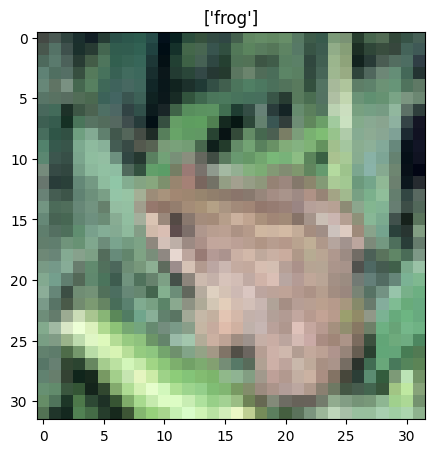

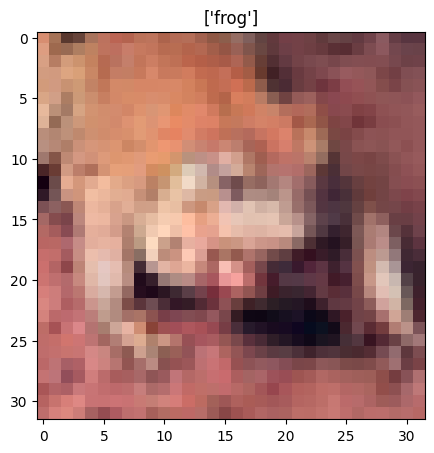

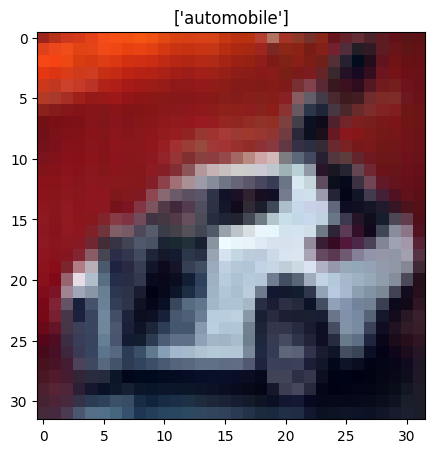

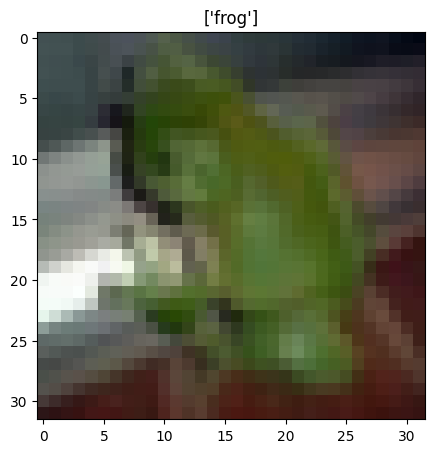

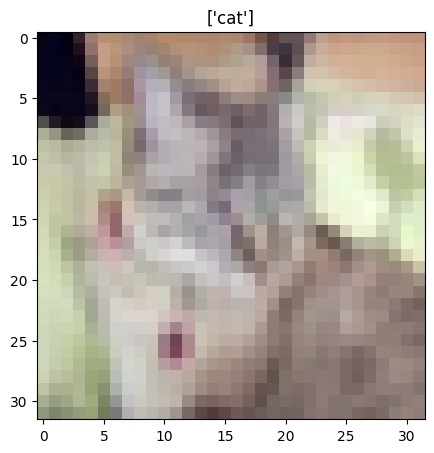

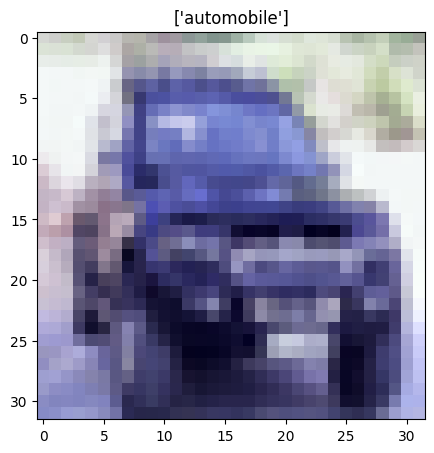

Accuracy of test text: 92.050000 %


In [13]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0


for idx, (images, labels) in enumerate(normal_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    if idx < 10:
        imshow(
            torchvision.utils.make_grid(images.cpu(), normalize=True),
            [normal_data.classes[i] for i in preds],
        )
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 5. Adversarial Attack

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations

In [22]:
# CIFAR-10 constants used in your transform
# reshapes to broadcast over NCHW batches: (N,3,H,W).
MEAN = torch.tensor([0.4914, 0.4822, 0.4465], device=device).view(1, 3, 1, 1) 
STD = torch.tensor([0.2470, 0.2435, 0.2616], device=device).view(1, 3, 1, 1)

def pgd_attack(model, images, labels, eps=8/255, alpha=2/255, iters=40):
    """
        Projected Gradient Descent (L∞) in **normalized space**.

        This routine performs an untargeted PGD attack by taking sign-gradient
        steps on the **normalized** inputs, projecting after each step onto the
        L∞ ball of radius `eps / STD` (per channel) around the original normalized
        image, and clipping to the valid normalized bounds that map to pixel [0,1].

        Parameters
        ----------
        model : nn.Module
            Model that expects normalized inputs; should be in `eval()` mode.
        images : torch.Tensor
            Normalized batch of shape (N, C, H, W), where `images = (x - MEAN) / STD`.
        labels : torch.Tensor
            Ground-truth class indices of shape (N,).
        eps : float, optional
            L∞ budget in pixel units (e.g., 8/255). Internally converted to normalized units by dividing by `STD`.
        alpha : float, optional
            Step size per iteration in pixel units (e.g., 2/255). Internally converted to normalized units by dividing by `STD`.
        iters : int, optional
            Number of PGD iterations.

        Returns
        -------
        torch.Tensor
            Adversarial images in **normalized space** (same shape/device as `images`).

        Notes
        -----
        - This is the **untargeted** variant (maximizes CE on the true labels).
        - Projection and clipping are in normalized space with bounds:
        `z_min = (0 - MEAN) / STD` and `z_max = (1 - MEAN) / STD`.

    """
    # put batches on device
    images = images.to(device)
    labels = labels.to(device)
    
    # create loss CE
    loss = nn.CrossEntropyLoss()

    # scale eps/alpha to normalized space
    # So a pixel-space change Δx maps to normalized change Δz = Δx/STD.
    # Do this per channel (hence tensors), so steps/budgets are correct after normalization
    eps_norm = eps / STD
    alpha_norm = alpha / STD

    # Save the anchor z₀ to project around.
    # .detach() ensures no gradient history is kept for the anchor.
    ori_images = images.clone().detach()

    # Repeat gradient steps + projection.
    for _ in range(iters):
        # Tell autograd to track gradients w.r.t. the current adversarial image images.
        images.requires_grad = True
        # Forward pass (model expects normalized inputs).
        outputs = model(images)

        # Clear parameter grads; backprop CE to get ∂L/∂images.
        # (You’re not updating model params here; zeroing is harmless/clean.)
        model.zero_grad()
        loss(outputs, labels).backward()

        # L∞ steepest-ascent direction: elementwise sign of the gradient.
        grad_sign = images.grad.sign()

        # Take one ascent step in normalized space (scaled per channel).
        adv_images = images + alpha_norm * grad_sign

        # Compute perturbation wrt the anchor: η = z - z₀.
        # Project η back to the L∞ ball of radius eps_norm (per-channel).
        eta = torch.clamp(adv_images - ori_images, min=-eps_norm, max=eps_norm)

        # clamp to normalized range
        # Recompose z = z₀ + η.
        # Clip to valid normalized range corresponding to pixel [0,1]:
	    # pixel 0 → normalized (-MEAN)/STD
	    # pixel 1 → normalized (1 - MEAN)/STD
	    # .detach() breaks the graph so the next loop starts fresh (so images.grad won’t accumulate).
        images = torch.clamp(ori_images + eta,
                             min=(-MEAN) / STD,
                             max=(1 - MEAN) / STD).detach()
    return images


In [19]:
print(device)

mps


Attack Image & Predicted Label


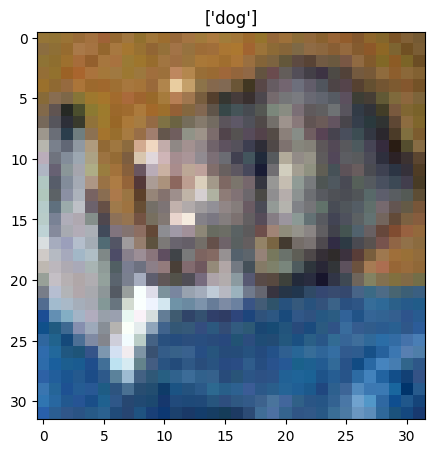

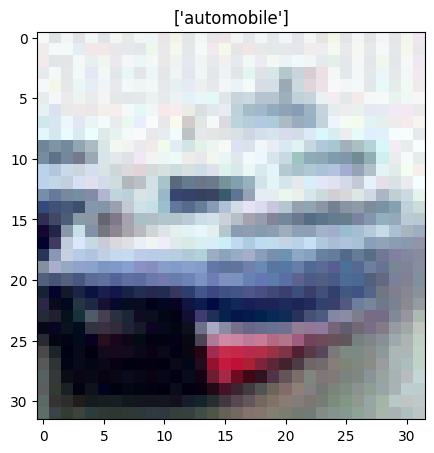

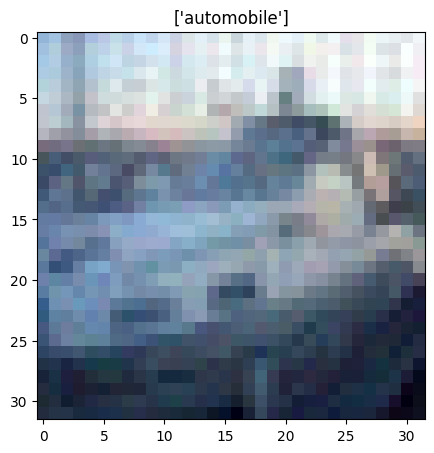

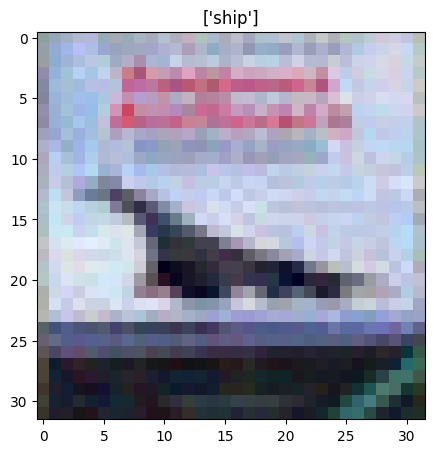

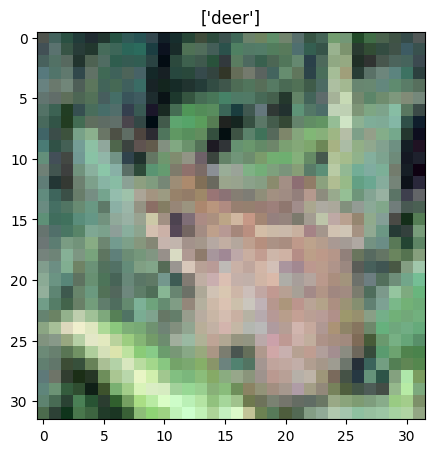

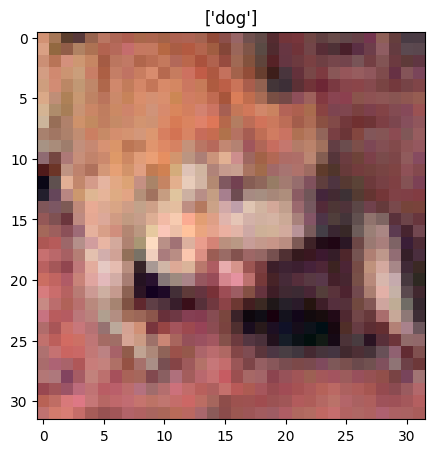

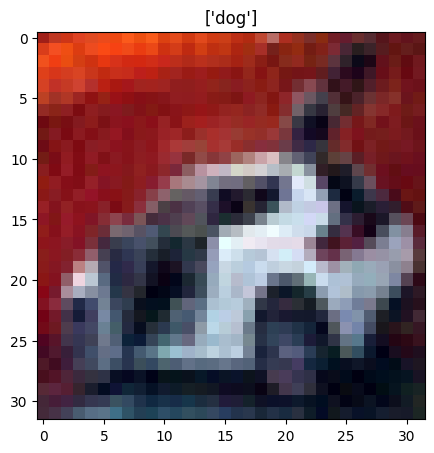

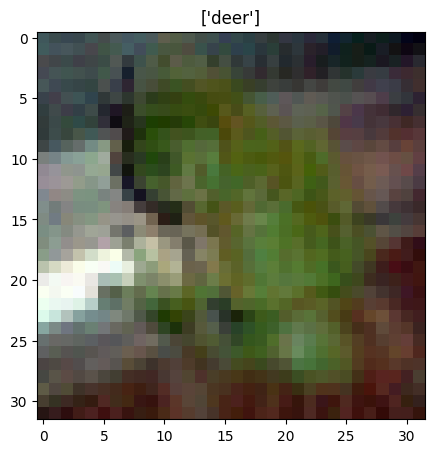

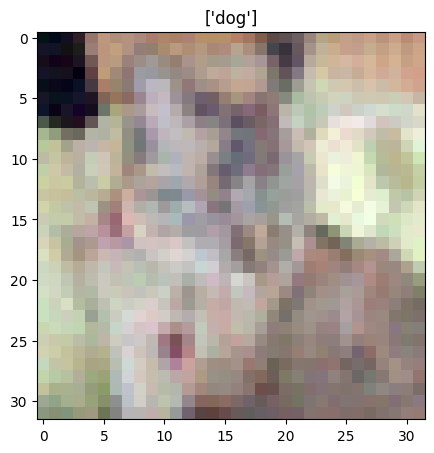

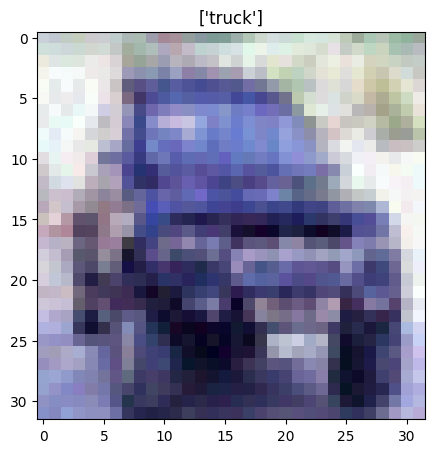

Accuracy of test text: 0.000000 %


In [21]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0
    
for idx, (images, labels) in enumerate(normal_loader):
    images = pgd_attack(model, images, labels)
    labels = labels.to(device)
    outputs = model(images)

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    if idx < 10:
        imshow(
            torchvision.utils.make_grid(images.cpu(), normalize=True),
            [normal_data.classes[i] for i in preds],
        )
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))